Spark MLLib
====

- [Official documentation](http://spark.apache.org/docs/latest/mllib-guide.html): The official documentation is clear, detailed and includes many code examples. You should refer to the official docs for exploration of this rich and rapidly growing library.

MLLib Pipeline
----

Generally, use of MLLIb for supervised and unsupervised learning follow some or all of the stages in the following template:

- Get data
- Pre-process the data
- Convert data to a form that MLLib functions require (*)
- Build a model
- Optimize and fit the model to the data
- Post-processing and model evaluation

This is often assembled as a pipeline for convenience and reproducibility. This is very similar to what you would do with `sklearn`, except that MLLib allows you to handle massive datasets by distributing the analysis to multiple computers.

### Set up Spark and Spark SQL contexts

In [1]:
from pyspark import SparkContext
sc = SparkContext('local[*]')

In [2]:
from pyspark.sql import SQLContext
sqlc = SQLContext(sc)

### Spark MLLib imports

The older `mllib` package works on RDDs. The newer `ml` package works on DataFrames. We will show examples using both, but it is more convenient to use the `ml` package.

In [3]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import PCA
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression

from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.clustering import GaussianMixture
from pyspark.mllib.classification import LogisticRegressionWithLBFGS, LogisticRegressionModel

Unsupervised Learning
----

We saw this machine learning problem previously with `sklearn`, where the task is to distinguish rocks from mines using 60 sonar numerical features. We will illustrate some of the mechanics of how to work with MLLib - this is not intended to be a serious attemtp at modeling the data.

### Obtain data

In [4]:
df = (sqlc.read.format('com.databricks.spark.csv')
      .options(header='false', inferschema='true')
      .load('data/sonar.all-data.txt'))

In [5]:
df.printSchema()

root
 |-- C0: double (nullable = true)
 |-- C1: double (nullable = true)
 |-- C2: double (nullable = true)
 |-- C3: double (nullable = true)
 |-- C4: double (nullable = true)
 |-- C5: double (nullable = true)
 |-- C6: double (nullable = true)
 |-- C7: double (nullable = true)
 |-- C8: double (nullable = true)
 |-- C9: double (nullable = true)
 |-- C10: double (nullable = true)
 |-- C11: double (nullable = true)
 |-- C12: double (nullable = true)
 |-- C13: double (nullable = true)
 |-- C14: double (nullable = true)
 |-- C15: double (nullable = true)
 |-- C16: double (nullable = true)
 |-- C17: double (nullable = true)
 |-- C18: double (nullable = true)
 |-- C19: double (nullable = true)
 |-- C20: double (nullable = true)
 |-- C21: double (nullable = true)
 |-- C22: double (nullable = true)
 |-- C23: double (nullable = true)
 |-- C24: double (nullable = true)
 |-- C25: double (nullable = true)
 |-- C26: double (nullable = true)
 |-- C27: double (nullable = true)
 |-- C28: double (nullabl

### Pre-process the data

In [6]:
df = df.withColumnRenamed("C60","label")

Transform 60 features into MMlib vectors

In [7]:
assembler = VectorAssembler(
    inputCols=['C%d' % i for i in range(60)],
    outputCol="features")
output = assembler.transform(df)

Scale features to have zero mean and unit standard deviation

In [8]:
standardizer = StandardScaler(withMean=True, withStd=True, 
                              inputCol='features', 
                              outputCol='std_features')
model = standardizer.fit(output)
output = model.transform(output)

Convert laebl to numeric index

In [9]:
indexer = StringIndexer(inputCol="label", outputCol="label_idx")
indexed = indexer.fit(output).transform(output)

Extract only columns of interest

In [10]:
sonar = indexed.select(['std_features', 'label', 'label_idx'])

In [11]:
sonar.show(n=3)

+--------------------+-----+---------+
|        std_features|label|label_idx|
+--------------------+-----+---------+
|[-0.3985897356694...|    R|      1.0|
|[0.70184498705605...|    R|      1.0|
|[-0.1289179854363...|    R|      1.0|
+--------------------+-----+---------+
only showing top 3 rows



### Data conversion

We will first fit a Gaussian Mixture Model with 2 components to the first 2 principal components of the data as an example of unsupervised learning. The GaussianMixture model requires an RDD of vectors, not a DataFrame. Note that `pyspark` converts `numpy` arrays to Spark vectors.

In [12]:
pca = PCA(k=2, inputCol="std_features", outputCol="pca")
model = pca.fit(sonar)
transformed = model.transform(sonar)

In [13]:
features = transformed.select('pca').rdd.map(lambda x: np.array(x))

In [14]:
features.take(3)

[array([[-1.91654441,  1.36759373]]),
 array([[ 0.47896904, -7.56812953]]),
 array([[-3.84994003, -6.42436107]])]

### Build Model

In [15]:
gmm = GaussianMixture.train(features, k=2)

### Optimize and fit the model to data

Note that we are looking at optimistic in-sample errors.

In [16]:
predict = gmm.predict(features).collect()

In [17]:
labels = sonar.select('label_idx').rdd.map(lambda r: r[0]).collect()

### Post-processing and model evaluation

The GMM is poor at clustering rocks and mines based on the first 2 PC of the sonographic data.

In [18]:
np.corrcoef(predict, labels)

array([[ 1.        , -0.13825324],
       [-0.13825324,  1.        ]])

Plot discrepancy between predicted and labels

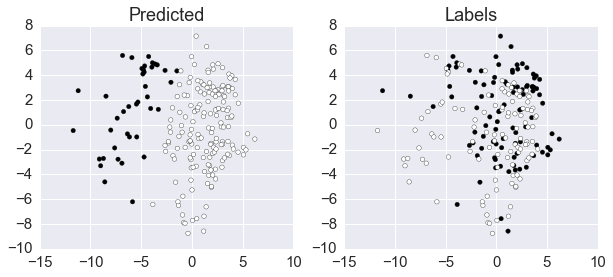

In [19]:
xs = np.array(features.collect()).squeeze()

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].scatter(xs[:, 0], xs[:,1], c=predict)
axes[0].set_title('Predicted')
axes[1].scatter(xs[:, 0], xs[:,1], c=labels)
axes[1].set_title('Labels')
pass

Supervised Learning
----

We will fit a logistic regression model to the data as an example of supervised learning.

In [20]:
sonar.show(n=3)

+--------------------+-----+---------+
|        std_features|label|label_idx|
+--------------------+-----+---------+
|[-0.3985897356694...|    R|      1.0|
|[0.70184498705605...|    R|      1.0|
|[-0.1289179854363...|    R|      1.0|
+--------------------+-----+---------+
only showing top 3 rows



### Using `mllib` and RDDs

Convert to format expected by regression functions in `mllib`

In [21]:
data = sonar.map(lambda x: LabeledPoint(x[2], x[0]))

Split into test and train sets

In [22]:
train, test = data.randomSplit([0.7, 0.3])

Fit model to training data

In [23]:
model = LogisticRegressionWithLBFGS.train(train)

Evaluate on test data

In [24]:
y_yhat = test.map(lambda x: (x.label, model.predict(x.features)))
err = y_yhat.filter(lambda x: x[0] != x[1]).count() / float(test.count())
print("Error = " + str(err))

Error = 0.26229508196721313


Using the newer `ml` pipeline
----

In [25]:
transformer = VectorAssembler(inputCols=['C%d' % i for i in range(60)],
                              outputCol="features")
standardizer = StandardScaler(withMean=True, withStd=True, 
                              inputCol='features', 
                              outputCol='std_features')
indexer = StringIndexer(inputCol="C60", outputCol="label_idx")
pca = PCA(k=5, inputCol="std_features", outputCol="pca")
lr = LogisticRegression(featuresCol='std_features', labelCol='label_idx')

pipeline = Pipeline(stages=[transformer, standardizer, indexer, pca, lr])

In [26]:
df = (sqlc.read.format('com.databricks.spark.csv')
      .options(header='false', inferschema='true')
      .load('data/sonar.all-data.txt'))

In [27]:
train, test = df.randomSplit([0.7, 0.3])

In [28]:
model = pipeline.fit(train)

In [29]:
import warnings

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    prediction = model.transform(test)

In [30]:
score = prediction.select(['label_idx', 'prediction'])
score.show(n=score.count())

+---------+----------+
|label_idx|prediction|
+---------+----------+
|      0.0|       0.0|
|      0.0|       0.0|
|      0.0|       0.0|
|      0.0|       0.0|
|      0.0|       0.0|
|      0.0|       0.0|
|      0.0|       0.0|
|      0.0|       0.0|
|      0.0|       1.0|
|      0.0|       0.0|
|      0.0|       0.0|
|      0.0|       1.0|
|      0.0|       0.0|
|      0.0|       1.0|
|      0.0|       0.0|
|      0.0|       0.0|
|      0.0|       0.0|
|      0.0|       1.0|
|      0.0|       0.0|
|      1.0|       0.0|
|      0.0|       0.0|
|      0.0|       0.0|
|      0.0|       1.0|
|      1.0|       0.0|
|      1.0|       1.0|
|      1.0|       0.0|
|      0.0|       0.0|
|      1.0|       1.0|
|      1.0|       1.0|
|      1.0|       1.0|
|      1.0|       1.0|
|      1.0|       1.0|
|      1.0|       1.0|
|      1.0|       1.0|
|      1.0|       0.0|
|      1.0|       1.0|
|      1.0|       0.0|
|      1.0|       1.0|
|      1.0|       1.0|
|      1.0|       1.0|
|      1.0|

In [31]:
acc = score.map(lambda x: x[0] == x[1]).sum() / score.count()
acc

0.765625

Spark MLLIb and `sklearn` integration
----

There is a package that you can install with

```bash
pip install spark-sklearn
```

Basically, it provides the same API as `sklearn` but uses Spark MLLib under the hood to perform the actual computations in a distributed way (passed in via the SparkContext instance).

### Example taken directly from package website

Install if necessary

```
! pip install spark_sklearn
```

In [34]:
from sklearn import svm, grid_search, datasets
from spark_sklearn import GridSearchCV
iris = datasets.load_iris()
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
svr = svm.SVC()
clf = GridSearchCV(sc, svr, parameters)
clf.fit(iris.data, iris.target)

GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'kernel': ('linear', 'rbf'), 'C': [1, 10]},
       pre_dispatch='2*n_jobs', refit=True,
       sc=<pyspark.context.SparkContext object at 0x10435ef60>,
       scoring=None, verbose=0)